In [13]:
# Network Data Science 
import networkx as nx

# Data Wrangling
import numpy as np

# Network Data Analysis 
import networkx as nx

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
%pylab inline

# Geo-Spatial Data Analysis
import geopandas as gpd
import pandas as pd
import contextily
from shapely.geometry import Point

# Other Utilities
from operator import itemgetter
from collections import defaultdict

Populating the interactive namespace from numpy and matplotlib


In [14]:
# Set filepath (fix path relative to yours)
italy_regions = "/Users/pietromonticone/github/DigitalEpidemiologyProject/Data/Shape/Reg01012020/Reg01012020_WGS84.shp"
italy_provinces = "/Users/pietromonticone/github/DigitalEpidemiologyProject/Data/Shape/ProvCM01012020/ProvCM01012020_WGS84.shp"
italy_municipalities = "/Users/pietromonticone/github/DigitalEpidemiologyProject/Data/Shape/Com01012020/Com01012020_WGS84.shp"
italy_macroregions = "/Users/pietromonticone/github/DigitalEpidemiologyProject/Data/Shape/RipGeo01012020/RipGeo01012020_WGS84.shp"

# Read file using gpd.read_file()
regions = gpd.read_file(italy_regions)
provinces = gpd.read_file(italy_provinces)
municipalities = gpd.read_file(italy_municipalities)
macro_regions = gpd.read_file(italy_macroregions)

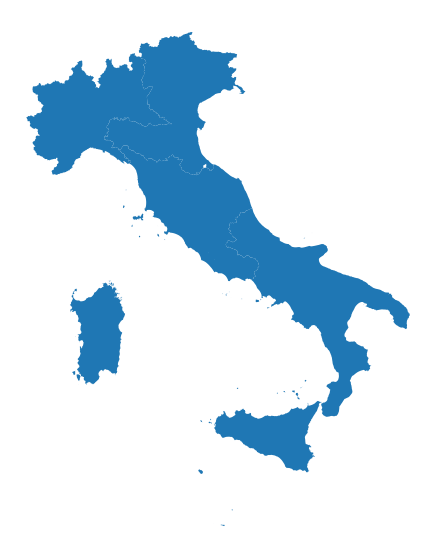

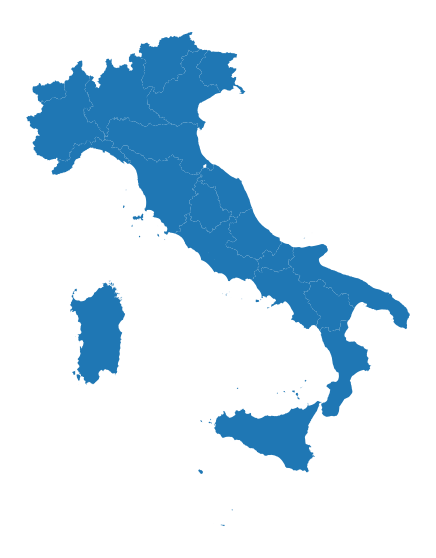

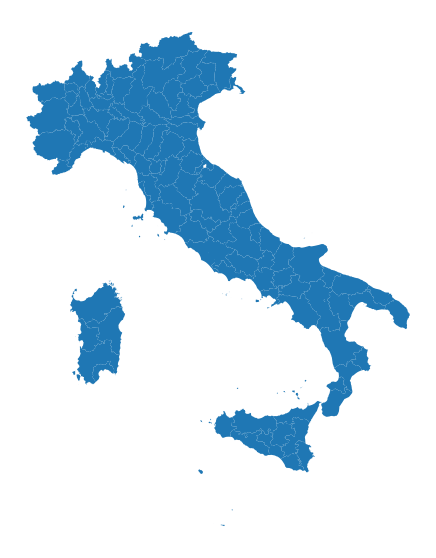

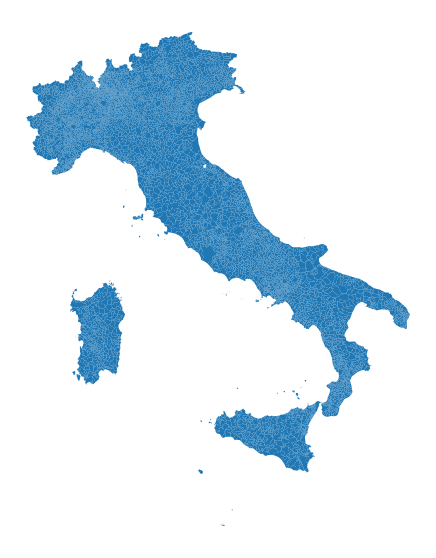

In [12]:
macro_regions.plot(figsize=(10, 10)).set_axis_off()
regions.plot(figsize=(10, 10)).set_axis_off()
provinces.plot(figsize=(10, 10)).set_axis_off()
municipalities.plot(figsize=(10, 10)).set_axis_off()

## Deterministic SIR 
This is teh simplest model. SIR is defined by three coupled differential equation, with 3 parameters that defines transitions between compartments.
These equations do not admit an analytic solution,  but one may solve by intoduciong some approximations (early stage  approximation ESA, in which the solution (the infected density) is an exponential of time * $\frac{\beta}{\mu}$ where $\beta$ is the transmission rate and $\mu$ the recovery rate. If $\beta > \mu$, the number of infected explodes.

* Continuous time 
* Deterministic

$$ \dot{S} = - \beta S I $$
$$ \dot{I} = \beta S I - \mu I $$
$$ \dot{R} = \mu I $$

In the asymptotic (initial time) regime 

$$i = \frac{I}{N} \sim 0$$
$$s = \frac{S}{N} \sim 1$$
$$ R_0 = \frac{\beta}{\mu}$$

* Single-run simulation
* Basic reproduction number $R_0 = 3.0$

We will solve (approximatley) the differntial equations and see the evolution of S(t) I(t) R(t) varaibles.

### Parameters

In [15]:
# let's choice some parameters value. Let's choose to be in the case where the infection explodes
mu = 0.2           # Recovery rate 
R0 = 3.0           # Basic reproduction number 
beta = R0 * mu    # Transmission rate

print("The average infectious period (average duration of the infectious period of an infected) is ", 1./mu, " days")

The average infectious period (average duration of the infectious period of an infected) is  5.0  days


### Initial Conditions

In [16]:
N = 10000     # Population size
I = 10        # Initial Infected & infectious subpopulation
S = N-I       # Initial Susceptible subpopulation 
R = 0         # Removed / Recovered subpopulation

### Single-Run Simulation

In [17]:
# Create time series list (time evolution as function of time step)
St = []
It = []
Rt = []

# Create list of differences between S and I values along contiguous time steps
deltaSt = []
deltaIt = []

# Populate time series with initial conditions 
St.append(S)   
It.append(I)
Rt.append(R)

# Implement the dynamical model 
while I>0.01: #I is a float (see its update below)
    i = float(I) * S/N
    # how many S become I (at each time step). this is a non-spontaneous transition
    deltaSI = beta * i
    
    # how many I become R (at each time step)
    deltaIR = mu * I
    
    
    S = S-deltaSI
    I = I + deltaSI-deltaIR
    R = R + deltaIR
    
    deltaSt.append(deltaSI)
    deltaIt.append(deltaIR)
    St.append(S)
    It.append(I)
    Rt.append(R)

# the total fraction of people infected during the whole epideimc process
print("The final attack rate is ", Rt[-1]/N) #0.95 note: R0 = 3 is teh value of R0 observed for covid19 at the early stage

The final attack rate is  0.9532865500506721


### Visualization

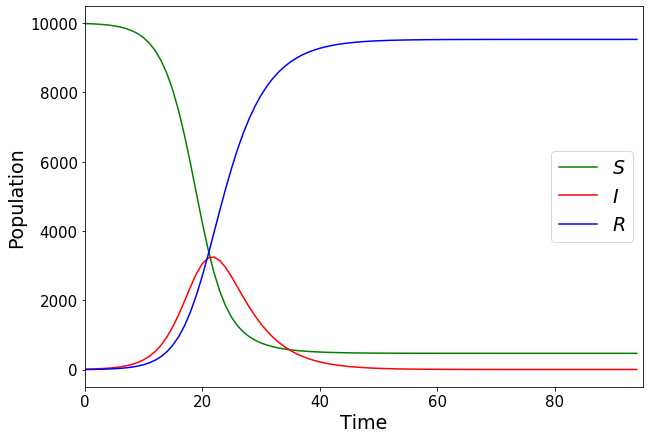

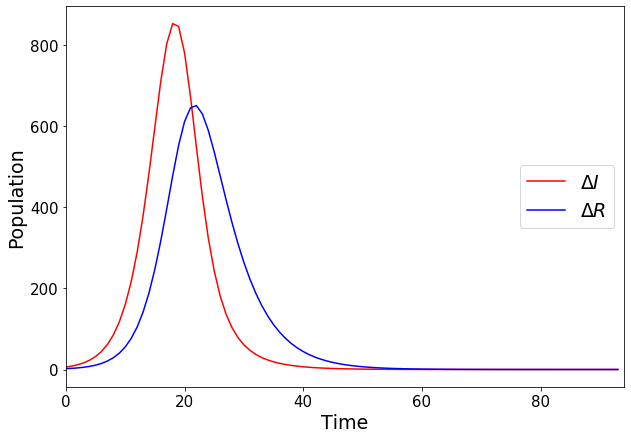

In [18]:
# Plot the S,I,R trajectories 
plt.figure(figsize = (10,7))

plt.plot(range(0, len(St)),np.array(St), label = '$S$', color = 'g')
plt.plot(range(0, len(It)),np.array(It), label = '$I$', color = 'r')
plt.plot(range(0, len(Rt)),np.array(Rt), label = '$R$', color = 'b')

#plt.yscale('log')
plt.xlim([0,len(It)])
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Time', fontsize = 19)
plt.ylabel('Population', fontsize = 19)
plt.legend(loc = 'right', fontsize = 19)

# Plot the dS,dI,dR trajectories 

plt.figure(figsize = (10,7))

plt.plot(range(0, len(deltaSt)),np.array(deltaSt), label = '$\Delta I$', color = 'r')
plt.plot(range(0, len(deltaIt)),np.array(deltaIt), label = '$\Delta R$', color = 'b')
#plt.plot(range(0, len(Rt)),np.array(Rt), label = 'R', color = 'y')

#plt.yscale('log')
plt.xlim([0,len(deltaIt)])

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Time', fontsize = 19)
plt.ylabel('Population', fontsize = 19)
plt.legend(loc = 'right', fontsize = 19)

Real epidemic curves do not follow the smooth trend we see above, but have fluctuations. These are introduced in the:

## Stochastic SIR

We simulate a discrete and stochastic SIR model by randomly extracting the transition elements at each time step. Since the simulations are stochastic, we need to run several realizations of the model and their statistical averages.

* Discrete time 
* Stochastic $\sim B(X,p)$
* Multi-run simulation
* Extract their statistical averages.
* Basic reproduction number $R_0 = 3.0$

### Parameters

In [19]:
mu = 0.2           # Recovery rate 
R0 = 3.0           # Basic reproduction number 
beta = R0 * mu     # Transmission rate

print("The average infectious period is ", 1./mu, " days")

The average infectious period is  5.0  days


Because of stocasticity, we will run the model multiple times with same initial parameters, and measure the dependence of S I R variables on fluctiations. Here we only care about I ( for simplicity)

### Multi-Run Simulation

In [20]:
I_dict = defaultdict(list)   # Define the time series dictionary for I 
R_final = []                 # Define the multi-run list for final R
nrun = 1000                  # Set the number of runs  
Irun = []                    # Define the multi-run list of lists for I. we will save total infected number for every run.

for run in range(0,nrun):
    
    # Set initial conditions at each run as before
    N = 10000         # Population size
    I = 10            # Infected & infectious subpopulation
    S = N - I         # Susceptible subpopulation 
    R = 0             # Removed / Recovered subpopulation
    t = 0             # Initialize the clock
    
    I_list = []         # Define the single-run list for I 
    I_list.append(I)    # Initialize the single-run list for I
    I_dict[t].append(I) # Initialize the time series dictionary for I
    
    # Implement the dynamical model 
    while I>0: # see below
        
        i = float(I)/N
        # probabiliy that an S becomes I
        p = beta * i
        
        # S extraction from a binomial (bernoullian) with probability of success (get infected) p. Note that the output is an integerm thus the above conditon I> 0
        deltaSI = np.random.binomial(S,p)
        deltaIR = np.random.binomial(I,mu)
        
        S = S - deltaSI
        I = I + deltaSI - deltaIR
        R = R + deltaIR
        
        t += 1
        r = float(R)/N
        
        I_list.append(I)
        I_dict[t].append(I)
    
    R_final.append(r)
    Irun.append(I_list)

print("The average final attack rate is ", np.average(np.array(R_final))) # close to the deterministic one

The average final attack rate is  0.9533109


### Visualization

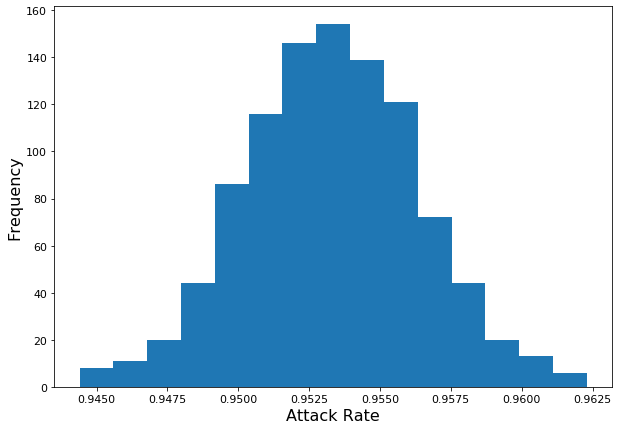

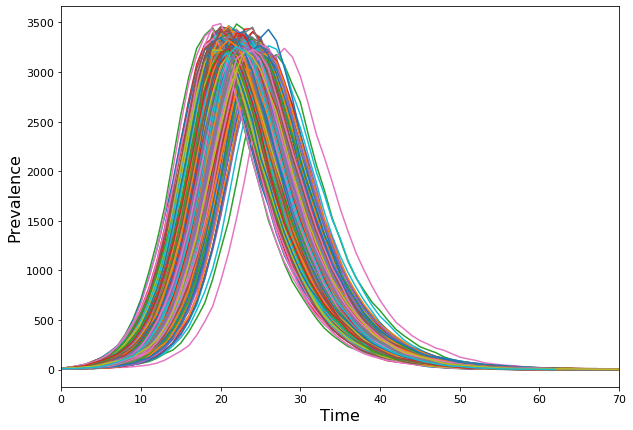

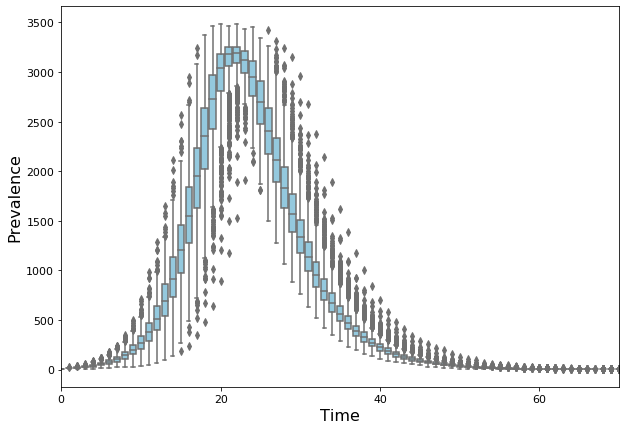

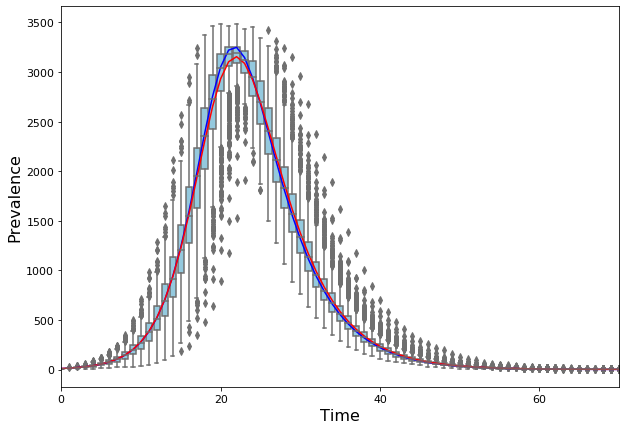

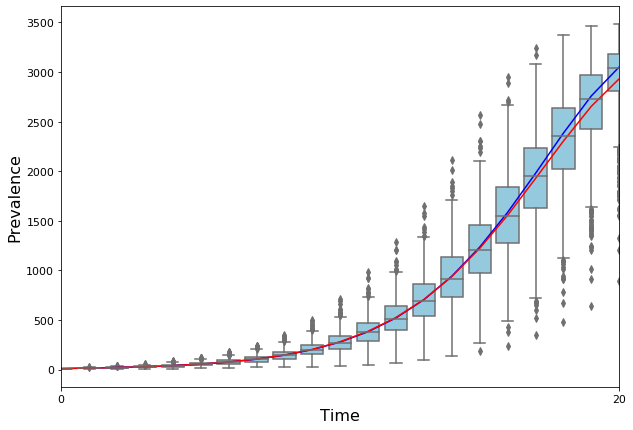

In [21]:
# 1. Plot the distribution of final attack rates
plt.figure(figsize = (10,7))
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.xlabel('Attack Rate', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)

a = plt.hist(R_final, bins = 15)

# 2. Plot the ensemble of trajectories
plt.figure(figsize = (10,7))
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.xlabel('Time', fontsize = 16)
plt.ylabel('Prevalence', fontsize = 16)
plt.xlim([0, 70])

for run in Irun: 
    plt.plot(range(0,len(run)),run)
    

# third plot is a boxplot. given a distribtuion (like teh one in the first plot), you may represent it with by an indication of the median (here nor shown), them some overlappin vertical segments (or boxes)that delimi where the 50% and 95% of data lies (percentiles/quantiles). So for example we choose  atime (es t = 20) and take all the prevalence values at time 20 ( from the distributions of the second plot), evaluate its quantiles and draw a point (median, 50% of data and 95% of data) in the third plot
# 3. Make a box plot for prevalence. we don0t calculate standard deviation beacause we don't assume it is gaussian (?)
full_array = [np.array(I_dict[t]) for t in I_dict]

plt.figure(figsize = (10,7))
plt.xlabel('Time', fontsize = 16)
plt.ylabel('Prevalence', fontsize = 16)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)

ax = sns.boxplot(data = full_array, color = 'skyblue')
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

plt.xlim([0, 70])

# overlap deterministic smooth curves with stocastic boxplots. note that the average of stocastic distribution (red curve) is very close to deterministic SIR prediction (blue curve). where we have frw outliers (at the beginning of the infection) red and blue curves are even closer.
# Compare the deterministic simulation vs. the average prevalence of the stochastic version
full_average = [np.average(np.array(I_dict[t])) for t in I_dict]

### 4. Make a box plot for prevalence: deterministic vs. averaged stochastic
plt.figure(figsize = (10,7))
plt.xlabel('Time', fontsize = 16)
plt.ylabel('Prevalence', fontsize = 16)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)

ax = sns.boxplot(data = full_array, color = 'skyblue')

plt.plot(range(0,len(It)),It,color = 'b') 
plt.plot(range(0,len(full_average)),full_average,color = 'r')

ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

plt.xlim([0,70])
plt.show()

### 5. Let's zoom in
plt.figure(figsize = (10,7))
plt.xlabel('Time', fontsize = 16)
plt.ylabel('Prevalence', fontsize = 16)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)

ax = sns.boxplot(data = full_array, color = 'skyblue')

plt.plot(range(0,len(It)),It,color = 'b') 
plt.plot(range(0,len(full_average)),full_average,color = 'r')

ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

plt.xlim([0,20])
plt.show()
# different runs show different attack rates
#prevalence = number of infected (?)

## Dependence on Initial Conditions

In [9]:
# Let's change the initial number of infected individuals to 1.

# Model parameters
## mu = 0.2
## R0 = 3.0
## beta = R0 * mu

I_dict = defaultdict(list)   # Define the time series dictionary for I 
R_final = []                 # Define the multi-run list for final R
nrun = 1000                  # Set the number of runs  
Irun = []                    # Define the multi-run list of lists for I 

for run in range(0,nrun):
    
    # Set initial conditions at each run 
    N = 10000         # Population size
    I = 1             # Infected & infectious subpopulation
    S = N - I         # Susceptible subpopulation 
    R = 0             # Removed / Recovered subpopulation
    t = 0             # Initialize the clock
    
    I_list = []         # Define the single-run list for I 
    I_list.append(I)    # Initialize the single-run list for I
    I_dict[t].append(I) # Initialize the time series dictionary for I
    
    # Implement the dynamical model 
    while I>0:
        
        i = float(I)/N
        p = beta * i
        
        deltaSI = np.random.binomial(S,p)
        deltaIR = np.random.binomial(I,mu)
        
        S = S - deltaSI
        I = I + deltaSI - deltaIR
        R = R + deltaIR
        
        t += 1
        r = float(R)/N
        
        I_list.append(I)
        I_dict[t].append(I)
    
    R_final.append(r)
    Irun.append(I_list)

print("The average final attack rate is ", np.average(np.array(R_final)))
# note this is very differnt from the 0.95 before. The only things we changed were th initial N I etc onditions. many times teh first infected recovered before infecting other people

The average final attack rate is  0.7062695999999999


### Visualization

[2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 7.0, 1.0, 9.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.9999999999999996, 1.0, 2.9999999999999996, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 5.999999999999999, 1.0, 4.0, 2.9999999999999996, 1.0, 1.0, 1.0, 1.0, 2.9999999999999996, 2.0, 2.0, 5.0, 2.9999999999999996, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.9999999999999996, 1.0, 2.9999999999999996, 2.9999999999999996, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.9999999999999996, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.9999999999999996, 2.9999999999999996, 1.0, 2.0, 1.0, 1.0, 5.0, 1.0, 

(array([  0., 100., 200., 300., 400., 500., 600., 700., 800.]),
 <a list of 9 Text major ticklabel objects>)

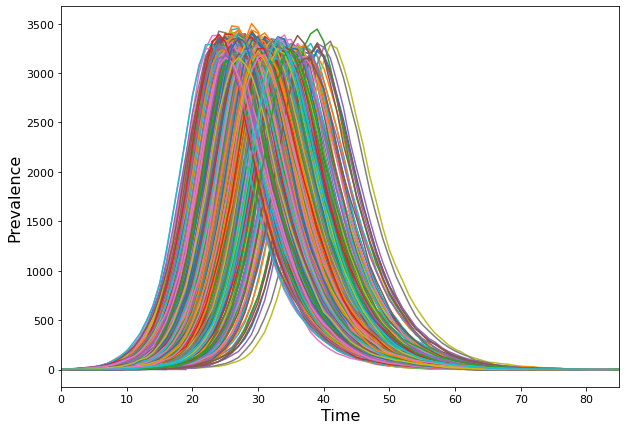

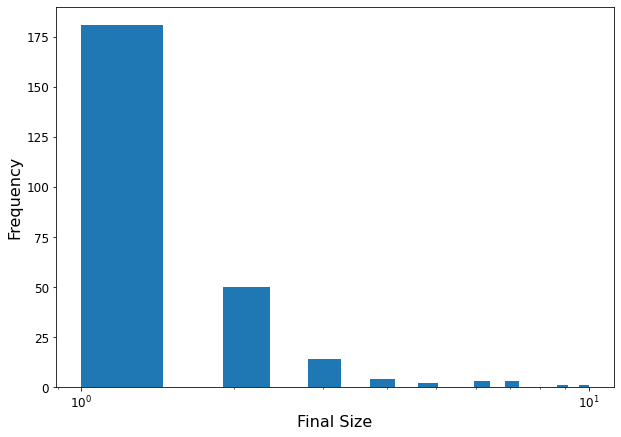

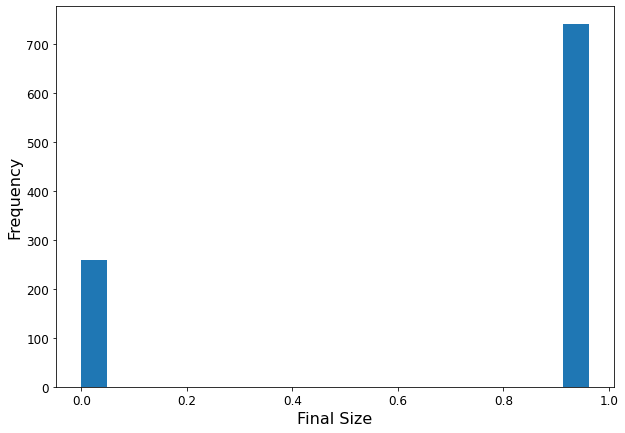

In [10]:
# Plot the ensemble of trajectories
plt.figure(figsize = (10,7))
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.xlabel('Time', fontsize = 16)
plt.ylabel('Prevalence', fontsize = 16)
plt.xlim([0, 85])

for run in Irun: 
    plt.plot(range(0,len(run)),run)
    
# With I_0 = 1 we see larger fluctuations: we have several runs without outbreak! 
## The initial seed individual recovers before infecting someone else.

# Plot the distribution of runs with no outbreak
# little numebr of initial cases is not suffivint to dtart an outrbeak even if R_0 > 1 
no_outbreak = []
for r in R_final:
    if r<0.8:
        no_outbreak.append(r * 10000)
print(no_outbreak)

plt.figure(figsize = (10,7))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Final Size', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
b = plt.hist(no_outbreak, bins = 20)
plt.xscale('log')


plt.figure(figsize = (10,7))
plt.hist(R_final, bins = 20)
plt.xlabel('Final Size', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

In a stochastic SIR model, the probability of an outbreak is equal to .We won't prove it, but you mayinterpret the folowing. R_0 is the number of people an infected infects before recovering in a population of Ss. In order to have an outbreak, I need this process to be sustained : an infected infects, and the new infecteds keep infecting other prople. The probability for it to happen is the probability that for every initial infected, other R_0 are generated.if the initial infected are few, this probability is small. nte taht in a deterministic model even few initial infecteds generate abn outbreak.
<center>
$p_{outb} = 1 - (\frac{1}{R_0})^{I_0}$
</center>

In [11]:
p_outbreak = 1-1/R0
p_outbreak

0.6666666666666667

Of course, such fluctuations do not affect the deterministic model, where the outcome is fixed. 

In [12]:
# Single-run deterministic simulation 

# Initial conditions 
N = 10000         # Population size
I = 1             # Infected & infectious subpopulation
S = N - I         # Susceptible subpopulation 
R = 0             # Removed / Recovered subpopulation
    
# Create time series list 
St = []
It = []
Rt = []

# Create list of differences
deltaSt = []
deltaIt = []

# Populate time series with initial conditions 
St.append(S)   
It.append(I)
Rt.append(R)

# Implement the dynamical model 
while I>0.01:
    i = float(I) * S/N
    deltaSI = beta * i
    
    deltaIR = mu * I
    
    S = S-deltaSI
    I = I + deltaSI-deltaIR
    R = R + deltaIR
    
    deltaSt.append(deltaSI)
    deltaIt.append(deltaIR)
    St.append(S)
    It.append(I)
    Rt.append(R)
    
print("The final attack rate is ", Rt[-1]/N)

The final attack rate is  0.9532189896643453


## Stochastic SIR on Static Network (US Airport)

Let's run SIR on a deterministic model

In [7]:
# Import datasets
airport_path = './../network_data/USairport_2010.txt'
meta_path = './../network_data/USairport_2010_codes.txt'

In [8]:
G = nx.Graph()
fh = open(airport_path,'r')
for line in fh.readlines():
    s = line.strip().split()
    G.add_edge(int(s[0]),int(s[1]))
fh.close()  

In [9]:
G.code = {}
G.name = {}
G.pos = {}

lons = []
lats = []

finfo = open(meta_path,'r')
finfo.readline()
for line in finfo.readlines():
    s = line.strip().split()
    node = int(s[0])
    
    lon = float(s[4])
    lat = float(s[3])
    
    G.code[node] = s[1]
    G.name[node] = s[2]
    G.pos[node] = [lon,lat]
    
    lons.append(lon)
    lats.append(lat)
finfo.close() 

In [10]:
#disease parameters
mu = 0.2#infectious period
lambd = 0.01#probability of infection given a contact
# note taht before the infectious rate beta was explicitly defined. Hgere instead it is given by the netrwork structure

In [11]:
#we need to store the disease status of each node
G.disease_status = {} #S = 0, I = 1, R = -1

infected_nodes = []#list of infected nodes

In [12]:
#let's choose a seed, whcih is teh airport to start the infection from
node_list = []

deg = dict(G.degree())
for i in sorted(deg.items(), key = itemgetter(1)):
    node_list.append(i[0])
seed = node_list[-1]

print("The seed is", G.name[seed])
print("The degree of the seed is", G.degree(seed))

The seed is Denver
The degree of the seed is 192


In [13]:
#initialize the network
infected_nodes.append(seed)

# let's set all node as subsceptible
for n in G.nodes():
    if n in infected_nodes:
        G.disease_status[n] = 1
        #infected
    else:
        G.disease_status[n] = 0
        #susceptible

In [14]:
I_net = []

while len(infected_nodes)>0:
    
    #transmission
    for i in infected_nodes:
        for j in G.neighbors(i):
            if G.disease_status[j] ==0:
                p = np.random.random()
                if p<lambd:
                    G.disease_status[j] = 1
                
    
    #recovery
    for k in infected_nodes:
        p = np.random.random()
        #if p is lesser than the recover probaility the node recovers
        if p<mu:
            G.disease_status[k] = -1
    
    #update of disease status
    infected_nodes = []
    for n in G.nodes():
        if G.disease_status[n] == 1:
            infected_nodes.append(n)
 
    #store output
    I_net.append(len(infected_nodes))

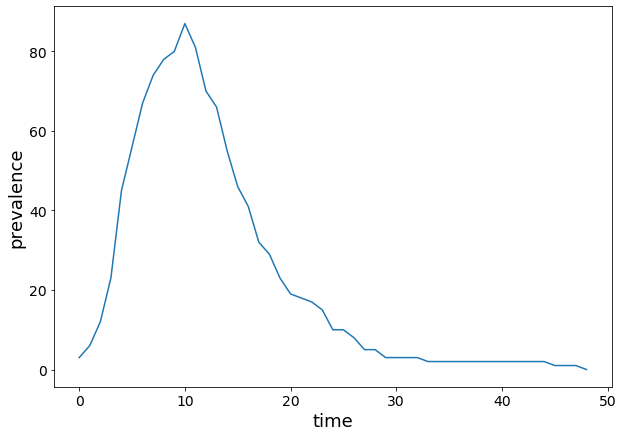

In [15]:
plt.figure(figsize = (10,7))

plt.xlabel('time', fontsize = 18)
plt.ylabel('prevalence', fontsize = 18)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.plot(range(0,len(I_net)),I_net)

In [16]:
recovered = 0
for n in G.nodes():
    if G.disease_status[n] == -1:
        recovered += 1

print("The total number of infected nodes is", recovered)
print("The final attack rate is", recovered/len(G.nodes()))
        

The total number of infected nodes is 223
The final attack rate is 0.5506172839506173


## Visualize the infection spread on the network

Let's visualize teh infection spread on a geograaphic map.

In [17]:
# geoandas allow to deal with shape files (.shp)
# if you lad an shp file, youalso load other auxiliary files
# shaley library is used to draw polygons, lines etc
shape_path = './../shapefiles/USA_shape.shp'

In [18]:
#ls ./../shapefiles/

In [19]:
#we need to store the disease status of each node
G.disease_status = {} #S = 0, I = 1, R = -1

infected_nodes = []#list of infected nodes

In [20]:
#initialize the network
infected_nodes.append(seed)

for n in G.nodes():
    if n in infected_nodes:
        G.disease_status[n] = 1
        #infected
    else:
        G.disease_status[n] = 0
        #susceptible

In [21]:
t = 0
node_color = [G.disease_status[v] for v in G]#color code on disease status

## Import the shapefile of the USA

In [25]:
# import the shape file

In [26]:
usa = gpd.read_file(shape_path)

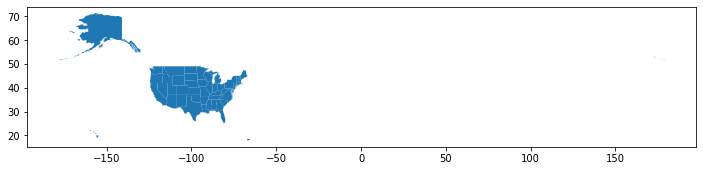

In [27]:
usa.plot(figsize = (12,7))
# we will be intersted only in the continenatl US (no alaska and isles)

In [28]:
# a shape file is made of tyhe geometric info needed to plot and features of regions
# allp andas functions also work in geoipandas
usa.head()

,AREA,PERIMETER,ST99_D00_,ST99_D00_I,STATE,NAME,LSAD,REGION,DIVISION,LSAD_TRANS,geometry
0,271.25438,227.17142,2,1,02,Alaska,01,4,9,None,"POLYGON ((-147.78711 70.24536, -147.76510 70.2..."
1,0.00375,0.34984,3,2,02,Alaska,01,4,9,None,"POLYGON ((-166.05315 66.26494, -166.03187 66.2..."
2,0.00150,0.15353,4,3,02,Alaska,01,4,9,None,"POLYGON ((-168.89322 65.74470, -168.89875 65.7..."
3,0.03130,0.71223,5,4,02,Alaska,01,4,9,None,"POLYGON ((-168.21012 64.99896, -168.20791 65.0..."
4,0.88934,7.36032,6,5,02,Alaska,01,4,9,None,"POLYGON ((-171.73986 63.71712, -171.73321 63.7..."


In [29]:
usa_cont = usa[(usa.NAME !=  'Alaska') & (usa.NAME != 'Hawaii') & (usa.NAME !=  'Puerto Rico')]

In [30]:
usa_cont.head()

,AREA,PERIMETER,ST99_D00_,ST99_D00_I,STATE,NAME,LSAD,REGION,DIVISION,LSAD_TRANS,geometry
81,25.53950,31.40718,83,82,27,Minnesota,01,2,4,None,"POLYGON ((-95.15332 49.19311, -95.15342 49.249..."
82,20.85358,30.71739,84,83,53,Washington,01,4,9,None,"POLYGON ((-122.29069 49.00243, -122.28565 49.0..."
83,0.00152,0.17436,85,84,53,Washington,01,4,9,None,"POLYGON ((-123.09055 49.00198, -123.06793 49.0..."
84,45.07846,34.97623,86,85,30,Montana,01,4,8,None,"POLYGON ((-116.04919 49.00091, -116.00103 49.0..."
85,24.45683,29.19034,87,86,16,Idaho,01,4,8,None,"POLYGON ((-116.04919 49.00091, -116.04918 48.8..."


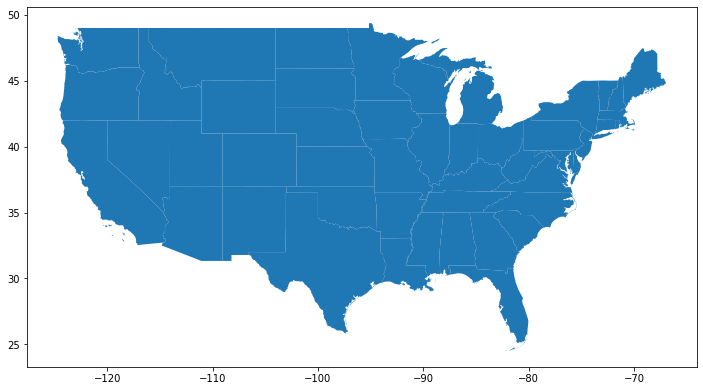

In [31]:
# when yo plot on a plane a portion of the planishere, you must choos e aprojection (a change of coordinate) .Geopandas default is vgs84 projection
usa_cont.plot(figsize = (12,7))

In [32]:
# crs = oordinat erefrence system. epsg:4326 is a coordinate system
usa_cont.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [57]:
# change crs. if it doesnt work it is not a problem, for it is just for aestetichs
usa_cont_alb = usa_cont.to_crs('esri:102003')
#usa_cont_alb = usa_cont.to_crs({'init':'esri:102003'})
#usa_cont_alb = usa_cont.to_crs({'init': 'epsg:102003'})

In [58]:
# if it worked, you woul see different coordinates for polygons (last column) , because the coordinate system changed
usa_cont_alb.head()

,AREA,PERIMETER,ST99_D00_,ST99_D00_I,STATE,NAME,LSAD,REGION,DIVISION,LSAD_TRANS,geometry
81,25.53950,31.40718,83,82,27,Minnesota,01,2,4,None,"POLYGON ((62537.915 1302915.952, 62474.888 130..."
82,20.85358,30.71739,84,83,53,Washington,01,4,9,None,"POLYGON ((-1922972.560 1549404.582, -1922612.9..."
83,0.00152,0.17436,85,84,53,Washington,01,4,9,None,"POLYGON ((-1979920.832 1565781.605, -1978310.3..."
84,45.07846,34.97623,86,85,30,Montana,01,4,8,None,"POLYGON ((-1474367.320 1437639.369, -1470869.8..."
85,24.45683,29.19034,87,86,16,Idaho,01,4,8,None,"POLYGON ((-1474367.320 1437639.369, -1478695.3..."


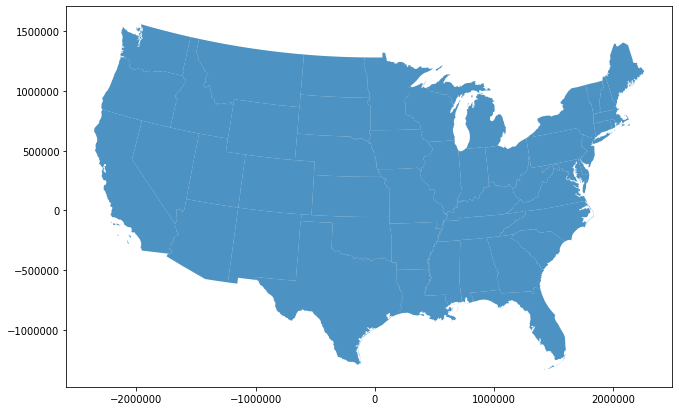

In [59]:
# if it works , youwould see a more commn representation (proportions)  of the usa
ax = usa_cont_alb.plot(figsize = (12,7), alpha = 0.8)

In [73]:
# moore coordinate system manipulation
from pyproj import Transformer

In [74]:
# create airport dataframe
df = pd.read_csv(meta_path, sep = ' ')

In [75]:
df

,id,code,city,lat,lon
0,29,ABE,Allentown,40.654722,-75.438333
1,30,ABI,Abilene,32.409444,-99.679722
2,32,ABQ,Albuquerque,35.041667,-106.606389
3,33,ABR,Aberdeen,45.449722,-98.421667
4,35,ABY,Albany,31.532222,-84.196111
...,...,...,...,...,...
410,1748,WYS,West_Yellowstone,44.686667,-111.104722
411,1752,XNA,Fayetteville,36.281944,-94.306944
412,1788,YKM,Yakima,46.566944,-120.537778
413,1795,YNG,Youngstown,41.256111,-80.669722


In [76]:
# using shapely's Point function, we create points froma list of tuples (lat and lon) that can be visyalized by geoplandas
geo = [Point(xy) for xy in zip(df.lon, df.lat)]
# standard coordinate system
crs = 'epsg:4326'
geo_df = gpd.GeoDataFrame(df, crs = crs, geometry = geo)

In [77]:
geo_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

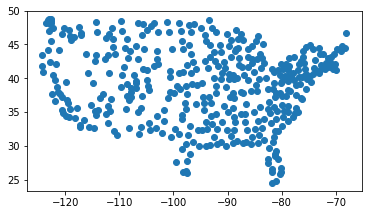

In [78]:
geo_df.plot()

In [95]:
transformer = Transformer.from_crs(geo_df.crs, "esri:102003")

In [96]:
# change coordinate system
G.pos_new = {}
for node in G:
    
    long,lat = G.pos[node]
    x,y = transformer.transform(long,lat)
    
    G.pos_new[node] = (x,y)

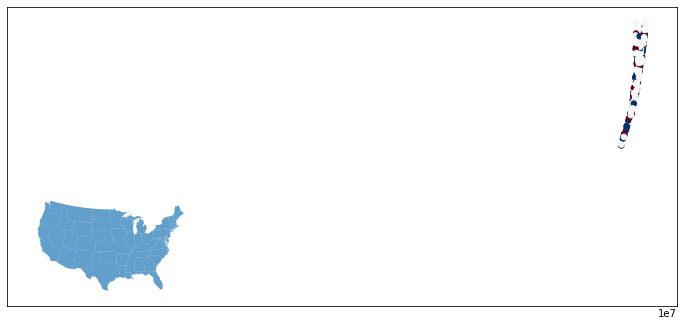

In [97]:
# draw node
ax = usa_cont_alb.plot(figsize = (12,7), alpha = 0.7)
nx.draw_networkx_nodes(G, pos = G.pos_new, node_size = 30,node_color = node_color, cmap = plt.cm.RdBu_r, vmin = -1, vmax = 1)

In [99]:
# run the simulation
while len(infected_nodes)>0 and t<15:
    
    for i in infected_nodes:
        for j in G.neighbors(i):
            if G.disease_status[j] == 0:
                p = np.random.random()
                if p<lambd:
                    G.disease_status[j] = 1
                
    for k in infected_nodes:
        p = np.random.random()
        if p<mu:
            G.disease_status[k] = -1
    
    infected_nodes = []
    for n in G.nodes():
        if G.disease_status[n] == 1:
            infected_nodes.append(n)

    t += 1
    node_color = [G.disease_status[v] for v in G]#color code on disease status
    
    plt.figure(figsize = (12,7))
    ax = usa_cont_alb.plot(figsize = (12,7), alpha = 0.7)
    nx.draw_networkx_nodes(G, pos = G.pos_new, node_size = 30,node_color = node_color, cmap = plt.cm.RdBu_r, vmin = -1, vmax = 1)
    
    #plt.savefig('./spreading_SIR_snapshot_time_' + str(t) + '.png')